In [1]:
import os
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from utils import load, get_audio_path, stereo_to_mono, frequency_mask, time_mask, plot_spectrogram
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [2]:
DATA_DIR = './fma/data/fma_small'

tracks = load('fma/data/fma_metadata/tracks.csv')
#features = utils.load('fma/data/fma_metadata/features.csv')
#echonest = utils.load('fma/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

#features_all = features.join(echonest, how='inner').sort_index(axis=1)

tracks = tracks.loc[subset]
#features_all = features.loc[subset]

train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

In [3]:
class FMA2D(Dataset):   
    
    
    def __init__(self, track_ids, use_subsamples=True, transforms=None, augment_prob=0.5):
        self.track_ids = track_ids
        self.subsamples = use_subsamples
        self.transforms = transforms
        self.augment_prob = augment_prob
        self.data_path = './fma/data/spectrograms_2/' if use_subsamples else './fma/data/spectrograms_1/'
        self.data = []
        if use_subsamples:
            for tid in track_ids:
                for i in range(7):
                    self.data.append([self.data_path +"{:06d}".format(tid)+f'_{i}.pt', tid])
        else:
            for tid in track_ids:
                self.data.append([self.data_path +"{:06d}".format(tid)+'.pt', tid])
    
    def __getitem__(self, index): 
        
        spec_path = self.data[index][0]
        tid = self.data[index][1]
        
        # load the spectrogram data
        try:
            spec = torch.load(spec_path)
        except Exception as e:
            return self.__getitem__(index + 1)
        
        if self.transforms and torch.rand(1) < self.augment_prob:
            spec = self.transforms[0](spec)
            spec = self.transforms[1](spec)
            
        
        label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        return spec, label
        
        
    def __len__(self):
        return len(self.data)


In [4]:
from networks_2D import ResNet34

torch.Size([32, 128, 216])


/home/prody/Documents/PoD_Y2_1/DLNN/PROJECT/utils.py:318: RuntimeWarning: divide by zero encountered in log
  cax = ax.matshow(np.log(spectrogram), origin='lower', aspect='auto', cmap='inferno')
/home/prody/Documents/PoD_Y2_1/DLNN/PROJECT/utils.py:318: RuntimeWarning: invalid value encountered in log
  cax = ax.matshow(np.log(spectrogram), origin='lower', aspect='auto', cmap='inferno')


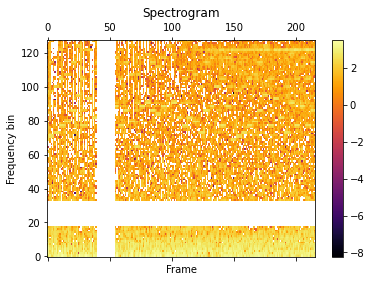

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 645]           3,136
       BatchNorm2d-2          [-1, 64, 64, 645]             128
              ReLU-3          [-1, 64, 64, 645]               0
         MaxPool2d-4          [-1, 64, 32, 323]               0
            Conv2d-5          [-1, 64, 32, 323]          36,864
              ReLU-6          [-1, 64, 32, 323]               0
            Conv2d-7          [-1, 64, 32, 323]          36,864
       BatchNorm2d-8          [-1, 64, 32, 323]             128
            Conv2d-9          [-1, 64, 32, 323]           4,096
      BatchNorm2d-10          [-1, 64, 32, 323]             128
             ReLU-11          [-1, 64, 32, 323]               0
       Res2DBlock-12          [-1, 64, 32, 323]               0
           Conv2d-13          [-1, 64, 32, 323]          36,864
             ReLU-14          [-1, 64, 

In [5]:
BATCH = 32
EPOCHS = 5
augment_prob = 0.8

# create a training dataset and dataloader
dataset = FMA2D(train, use_subsamples=True, transforms=[frequency_mask, time_mask], augment_prob=augment_prob)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

# create a validation dataset and dataloader
val_dataset = FMA2D(val, use_subsamples=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

# Lee 2017
# SGD optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)


for spec, label in dataloader:
    print(spec.size())
    plot_spectrogram(spec[0])
    input_size = spec.size()[2]
    break

p_dropout = 0.3
model = ResNet34(FN=64, p_dropout=p_dropout)
model.to(device)
summary(model, (1, 128, 1290))

# Adam optimizer01
lr = 0.001
optimizer = torch.optim.Adam(model.parameters())
optimizer_name = 'Adam'

timestamp = time.strftime("feb%d_t%H%M", time.gmtime())
model_name = f"{model.name}_B{BATCH}_E{EPOCHS}_O{optimizer_name}_LR{lr}_pD{p_dropout}_A{augment_prob}_{timestamp}"

[1, 44800 subsamples] Training loss: 1.868
[3.6226 min] Validation Loss: 1.6646 | Validation Accuracy: 0.3884 | Training Accuracy: 0.3085
[2, 89600 subsamples] Training loss: 1.693
[7.0341 min] Validation Loss: 1.5384 | Validation Accuracy: 0.4313 | Training Accuracy: 0.3732
[3, 134400 subsamples] Training loss: 1.630
[10.4556 min] Validation Loss: 1.6131 | Validation Accuracy: 0.4307 | Training Accuracy: 0.3975
[4, 179200 subsamples] Training loss: 1.586
[13.8856 min] Validation Loss: 1.5282 | Validation Accuracy: 0.4459 | Training Accuracy: 0.4168
[5, 224000 subsamples] Training loss: 1.539
[17.5106 min] Validation Loss: 1.5715 | Validation Accuracy: 0.4391 | Training Accuracy: 0.4387


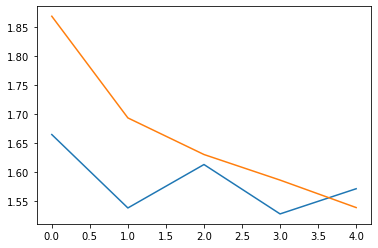

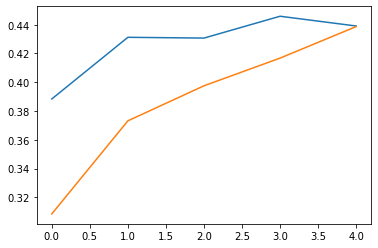

Finished Training


In [6]:


i = 0
running_loss = 0.0
best_val_loss = float('inf') # initialize the best validation loss


# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

t0 = time.time()

for epoch in range(EPOCHS):
    # evaluate the model on the training dataset
    train_correct = 0
    train_total = 0
    for spectrogram, label in dataloader:
            model.train()
            label = label.to(device)
            train_label = torch.argmax(label, dim=1)



            # forward pass
            spectrogram = spectrogram.squeeze(0)  
            spectrogram = spectrogram.unsqueeze(1)
            
            spectrogram = spectrogram.to(device)
            output = model(spectrogram)
            
            loss = loss_fn(output, label)

            # backward pass
            optimizer.zero_grad()
            model.zero_grad()
            loss.backward()
            optimizer.step()  
            
            # Update the learning rate
            # scheduler.step(loss)
            
            _, train_predicted = torch.max(output.data, 1)
            train_total += train_label.size(0)
            train_correct += (train_predicted == train_label).sum().item()
            # print statistics
            i += 1
            running_loss += loss.item()
            
            
    loss = running_loss / len(dataloader)
    loss_tr.append(loss)
    print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i*BATCH, loss))
    running_loss = 0            
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for val_spectrogram, val_label in val_dataloader:
                val_label = val_label.to(device)
                val_label = torch.argmax(val_label, dim=1)
            
                val_spectrogram = val_spectrogram.squeeze(0)
                val_spectrogram = val_spectrogram.unsqueeze(1)
                val_spectrogram = val_spectrogram.to(device)
                val_output = model(val_spectrogram)
                val_loss += loss_fn(val_output, val_label).item()
                _, val_predicted = torch.max(val_output.data, 1)
                val_total += val_label.size(0)
                val_correct += (val_predicted == val_label).sum().item()

    loss = val_loss / len(val_dataloader)
    loss_val.append(loss)
    val_acc = val_correct / val_total
    tr_acc = train_correct / train_total 
    acc_tr.append(tr_acc)
    acc_val.append(val_acc)
    t1 = time.time()
    t = (t1 - t0)/60
    # Save the model if the validation loss is the best seen so far
    if loss < best_val_loss:
        best_val_loss = loss
        best_val_acc = val_acc
        best_tr_acc = tr_acc
        best_state_dict = model.state_dict()
    print('[{:.4f} min] Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(t, loss, val_acc, tr_acc))

plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.show()

plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.show()

torch.save(best_state_dict, model_name + f'_VAL{best_val_acc}_TRAIN{best_tr_acc}.pt')
print('Finished Training')

In [8]:
# in case we keyboard interrupt the training process we can save the best model manually:
torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
print(model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
# model_name = "nnet1_2022-01-30_batchsize_32_epochs_100_opt_Adam_LR_0.0001_dropout1_acc0.373_subsampling"
# torch.save(model, model_name + '.pt')

ResNet34-M_B32_E30_OAdam_LR0.0001_pDNone_A0.8_feb10_t1418_VAL0.5498_TRAIN0.5672.pt


In [7]:
class FMA2DTest(Dataset):   
    
    
    def __init__(self, track_ids, use_subsamples=True):
        self.track_ids = track_ids
        self.subsamples = use_subsamples

        self.data_path = './fma/data/spectrograms_2/' if use_subsamples else './fma/data/spectrograms_1/'
        self.data = []
        for tid in track_ids:
            self.data.append([self.data_path +"{:06d}".format(tid), tid])

    
    def __getitem__(self, index): 
        
        sp_path = self.data[index][0]
        tid = self.data[index][1]
        spec = []
        # load the spectrogram data
        try:
            for idx in range(7):
                spec.append(torch.load(sp_path + f'_{idx}.pt'))
        except Exception as e:
            return self.__getitem__(index + 1)

            
        
        label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        return spec, label
        
        
    def __len__(self):
        return len(self.data)


## Testing +  aggregation + confusing matrix

In [ ]:
N_SUBSAMPLES = 7
# create a dataset object for testing
test_dataset = FMA2DTest(val)
batch_size = 32
# create a data loader to load the dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#p_dropout = 0.3
#model = nnet1(input_size=1290, num_classes=8)
#model = torch.load(f'{model_name}')
#saved_dict = torch.load(f'{model_name}')
#model.load_state_dict(saved_dict)

# test the model
model.eval()
model.to(device)
correct = 0
correct_agg = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad(): # don't need to track, calculate or save the gradients in the model
    for spec, labels in test_loader:
        labels = torch.argmax(labels, dim=1).cpu()
        batch_size = labels.size(0) # we reupdate the batch size because the last batch can be incomplete.
        subsample_outputs = {i: [] for i in range(batch_size)}
        for spectrogram in spec:
        
            spectrogram = spectrogram.to(device)
            spectrogram = spectrogram.squeeze(0)  
            spectrogram = spectrogram.unsqueeze(1)
            outputs = model(spectrogram)
            predicted = torch.argmax(outputs.data, dim=1).cpu()
            for j in range(batch_size):
                subsample_outputs[j].append(predicted[j]) 
                
        for j in range(batch_size):
            # count the occurrences of each class
            counts = np.bincount(subsample_outputs[j])
            # Find the class with the highest count
            aggregate_prediction = np.argmax(counts)
            correct += np.sum([subsample_outputs[j][i] == labels[j] for i in range(N_SUBSAMPLES)])
            correct_agg += (aggregate_prediction == labels[j])
            all_preds.append(aggregate_prediction)
            all_labels.append(labels[j])
            

        total += labels.size(0)

print('Test accuracy without aggregation: %f %%' % (100/7 * correct / total))
print('Test accuracy with aggregation: %f %%' % (100 * correct_agg / total))

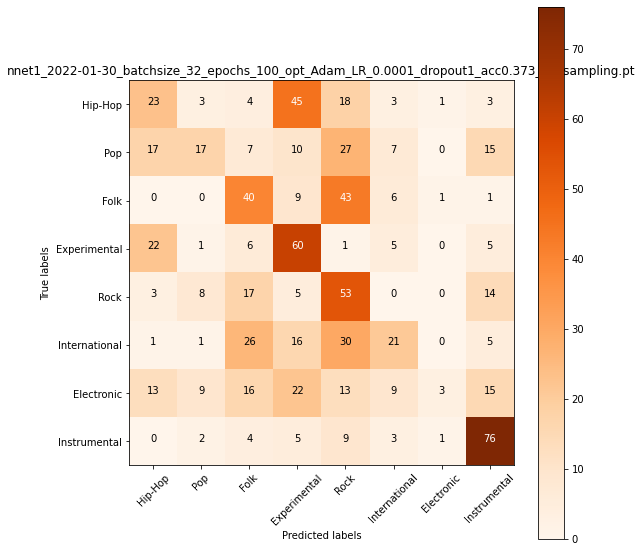

In [16]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):

     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
from sklearn.metrics import confusion_matrix    
import itertools
# a tuple for all the class names
genre = tracks.track.genre_top.unique().to_list()
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, genre, title=model_name)


## One batch check

In [ ]:
BATCH = 1

# create a training dataset and dataloader
dataset = FMA2D(train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)



# create a validation dataset and dataloader
val_dataset = FMA2D(val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH, shuffle=True)

    
# create the CNN model
model = nnet1(num_classes=8) # HERE YOU PUT UR NETWORK
model.to(device)

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

# Adam optimizer
#optimizer = torch.optim.Adam(model.parameters())


# Lee 2017
# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Define the scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)



num_epochs = 10
i = 0
running_loss = 0.0

import time
    
# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

spectrogram, label = next(iter(dataloader))
spectrogram = spectrogram.squeeze(-1)  
spectrogram = spectrogram.unsqueeze(0)

for epoch in range(num_epochs):
            # evaluate the model on the training dataset
            train_correct = 0
            train_total = 0
    #for spectrogram, label in dataloader:
            
            label = label.to(device)
            train_label = torch.argmax(label, dim=1)


            # forward pass
#             spectrogram = spectrogram.squeeze(-1)  
#             spectrogram = spectrogram.unsqueeze(0)
            
            spectrogram = spectrogram.to(device)
            output = model(spectrogram)
            print(spectrogram.size())
            loss = loss_fn(output, label)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  
            
            # Update the learning rate
            scheduler.step(loss)
            
            _, train_predicted = torch.max(output.data, 1)
            train_total += train_label.size(0)
            train_correct += (train_predicted == train_label).sum().item()
            # print statistics
            i += 1
            running_loss += loss.item()
            print(train_correct)
            
            
            
#     loss = running_loss / len(dataloader)
#     loss_tr.append(loss)
#     print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i*BATCH, loss))
#     running_loss = 0            
#     # evaluate the model on the validation dataset
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0
#     with torch.no_grad():
#         for val_spectrogram, val_label in val_dataloader:
#                 val_label = val_label.to(device)
#                 val_label = torch.argmax(val_label, dim=1)
            
#                 val_spectrogram = val_spectrogram.squeeze(-1)
#                 val_spectrogram = val_spectrogram.unsqueeze(0)
#                 val_spectrogram = val_spectrogram.to(device)
#                 val_output = model(val_spectrogram)
#                 val_loss += loss_fn(val_output, val_label).item()
#                 _, val_predicted = torch.max(val_output.data, 1)
#                 val_total += val_label.size(0)
#                 val_correct += (val_predicted == val_label).sum().item()

#     loss = val_loss / len(val_dataloader)
#     loss_val.append(loss)
#     val_acc = val_correct / val_total
#     tr_acc = train_correct / train_total 
#     acc_tr.append(tr_acc)
#     acc_val.append(val_acc)
#     print('Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(loss, val_acc, tr_acc))

plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.show()

plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.show()
    
print('Finished Training')